<a href="https://colab.research.google.com/github/navneetslovely/QML_genom/blob/main/peg_qsvm_zfeatureMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit-machine-learning
!pip install qiskit[visualization]
!pip install qiskit[torch]
!pip install genomic-benchmarks
!pip install tensorflow>=2.6.0
!pip install tensorflow-addons
!pip install typing-extensions --upgrade
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 943.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 8.1 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512614 sha256=1969c2b3154453ac993e121039b9863c0e36eb8ba2b9fc7ce44530ba7faf5517
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448da

In [2]:
from pathlib import Path
import os
import sys
import tensorflow as tf
import warnings
import numpy as np
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from genomic_benchmarks.loc2seq import download_dataset
from genomic_benchmarks.data_check import is_downloaded, info
from genomic_benchmarks.models.tf import vectorize_layer
from genomic_benchmarks.models.tf import get_basic_cnn_model_v0 as get_model
import matplotlib.pyplot as plt
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from functools import partial
# from qiskit import Aer
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.primitives import Sampler

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC
import json
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.decomposition import PCA
algorithm_globals.random_seed = 42

In [4]:
def download_genomic_dataset(dataset):
    if not is_downloaded(dataset):
        download_dataset(dataset)
        print("Dataset downloaded successfully")

In [3]:
# Function to load the dataset
def load_dataset(dataset_path, batch_size, seed):
    CLASSES = [x.stem for x in dataset_path.iterdir() if x.is_dir()]
    NUM_CLASSES = len(CLASSES)

    ds = tf.keras.preprocessing.text_dataset_from_directory(
        dataset_path,
        batch_size=batch_size,
        seed=seed,
        class_names=CLASSES,
    )
    return ds

In [5]:
# Function to vectorize text and labels
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)-2, label

In [6]:
# Function to preprocess and save the data
def preprocess_and_save_data(train_ds, test_ds):
    vectorize_layer.adapt(train_ds.map(lambda x, y: x))
    train_ds = train_ds.map(vectorize_text)

    vectorize_layer.adapt(test_ds.map(lambda x, y: x))
    test_ds = test_ds.map(vectorize_text)

    np_train_data_set = [{"sequence": text.tolist(), "label": label.tolist()} for text_list, label_list in train_ds for text, label in zip(text_list.numpy(), label_list.numpy())]

    np_test_data_set = [{"sequence": text.tolist(), "label": label.tolist()} for text_list, label_list in test_ds for text, label in zip(text_list.numpy(), label_list.numpy())]

    train_sequences = np.array([data_point["sequence"] for data_point in np_train_data_set])
    train_labels = np.array([data_point["label"] for data_point in np_train_data_set])
    test_sequences = np.array([data_point["sequence"] for data_point in np_test_data_set])
    test_labels = np.array([data_point["label"] for data_point in np_test_data_set])

    np.save("train_sequences.npy", train_sequences)
    np.save("train_labels.npy", train_labels)
    np.save("test_sequences.npy", test_sequences)
    np.save("test_labels.npy", test_labels)
    print("Data preprocessed and saved successfully")


    return train_sequences, train_labels, test_sequences, test_labels

In [7]:
DATASET = "demo_coding_vs_intergenomic_seqs"
dataset_path = Path.home() / '.genomic_benchmarks' / DATASET
print(f"Dataset path: {dataset_path}")
download_genomic_dataset(DATASET)

Dataset path: /root/.genomic_benchmarks/demo_coding_vs_intergenomic_seqs


Downloading...
From (original): https://drive.google.com/uc?id=1cpXg0ULuTGF7h1_HTYvc6p8M-ee43t-v
From (redirected): https://drive.google.com/uc?id=1cpXg0ULuTGF7h1_HTYvc6p8M-ee43t-v&confirm=t&uuid=31163019-3238-449d-b0fc-453457ad2330
To: /root/.genomic_benchmarks/demo_coding_vs_intergenomic_seqs.zip
100%|██████████| 33.9M/33.9M [00:00<00:00, 79.2MB/s]


Dataset downloaded successfully


In [8]:
train_ds = load_dataset(dataset_path / 'train', batch_size=64, seed=1337)
test_ds = load_dataset(dataset_path / 'test', batch_size=64, seed=1337)
train_sequences, train_labels, test_sequences, test_labels = preprocess_and_save_data(train_ds, test_ds)
print("Data loaded successfully")

Found 75000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Data preprocessed and saved successfully
Data loaded successfully


In [9]:
n_components=4
pca = PCA(n_components)  # for example, reduce to n dimensions
train_sequences_pca = pca.fit_transform(train_sequences)
test_sequences_pca = pca.fit_transform(test_sequences)
print("Train Sequences Shape after PCA with", n_components, "components:", train_sequences_pca.shape)
print("Test Sequences Shape after PCA with", n_components, "components:", test_sequences_pca.shape)

Train Sequences Shape after PCA with 4 components: (75000, 4)
Test Sequences Shape after PCA with 4 components: (25000, 4)


In [10]:
# Define the feature dimension or number of qubits
feature_dim = len(train_sequences_pca[0])
print("Feature dimension and number of qubits:", feature_dim)
# number of steps performed during the training procedure
tau = 100
# regularization parameter
C = 1000

Feature dimension and number of qubits: 4


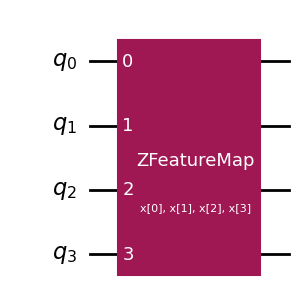

In [11]:
from qiskit.circuit.library import ZFeatureMap
feature_map = ZFeatureMap(feature_dim, reps=2)
feature_map.draw('mpl')

In [12]:
qkernel = FidelityQuantumKernel(feature_map=feature_map)
pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

In [13]:
num_epochs = 10
batch_size = 64
# Create a progress bar
print("Dataset size:", len(train_sequences_pca))
print("Number of epochs:", num_epochs)
print("Batch size:", batch_size)
print("Number of batches:", len(train_sequences_pca) // batch_size)

Dataset size: 75000
Number of epochs: 10
Batch size: 64
Number of batches: 1171


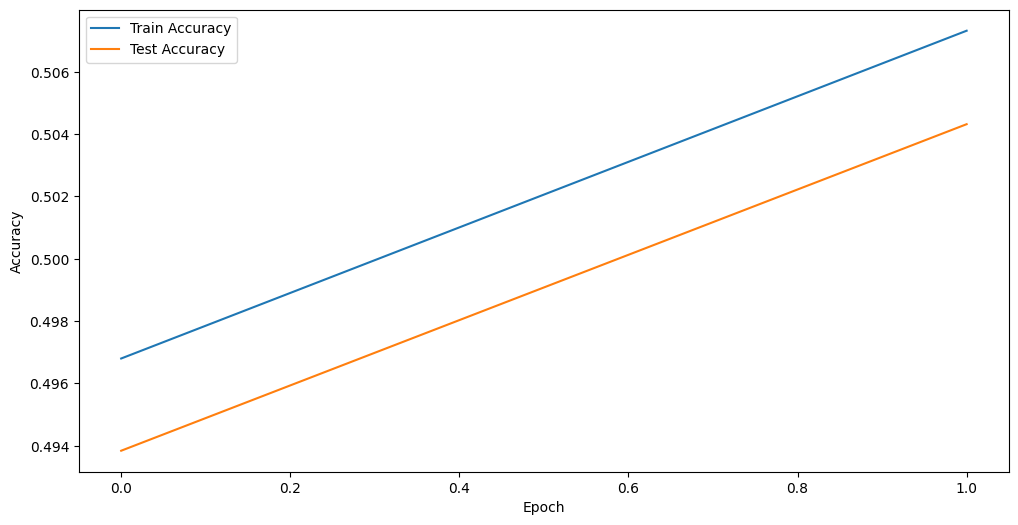

In [ ]:
from tqdm import tqdm
total_time = 0
history = {
  "train_accuracy": [],
  "test_accuracy": [],
}
for epoch in range(10):
  start = time.time()

  for epoch in range(num_epochs):# Perform training for each batch
    for i in range(0, len(train_sequences_pca), batch_size):
        batch_sequences = train_sequences_pca[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        # Perform training for the batch
        pegasos_qsvc.fit(batch_sequences, batch_labels)

    end = time.time()
    total_time += end - start
    print(f"Epoch {epoch+1}/{10}: Training time: {end - start:.3f} seconds")



    # Evaluate the model on the training and test sets
    train_accuracy = pegasos_qsvc.score(train_sequences_pca, train_labels)
    test_accuracy = pegasos_qsvc.score(test_sequences_pca, test_labels)

    # Update the history dictionary

    history["train_accuracy"].append(train_accuracy)
    history["test_accuracy"].append(test_accuracy)


    print(f"Epoch {epoch+1}/{10}: Train Accuracy: {train_accuracy:.3f}, Test Accuracy: {test_accuracy:.3f}")

    # log_file_path = "log_zfeatureMap.txt"
    # # Check if the log file already exists
    # if os.path.exists(log_file_path):
    #     # If the log file exists, append the log entry to a new line
    #     with open(log_file_path, "a") as log_file:
    #         log_file.write(f"\n{history}")
    # else:
    #     # If the log file does not exist, create a new log file and write the log entry
    #     with open(log_file_path, "w") as log_file:
    #         log_file.write(history)

    # Plot the training and test loss
    clear_output(wait=True)
    # Plot the training and test accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history["train_accuracy"], label="Train Accuracy")
    plt.plot(history["test_accuracy"], label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()